## Introduction
Topic Modeling is a modeling method in natural language processing which helps find 'topics' or groups of words from a set of documents. It helps us find patterns within text and is particularly helpful in situations where the we do no have a lot of domain or specialized knowledge about the document set. In this tutorial we will specifically look at Topic Modeling by focusing on a generative model called **Latent Dirichlet allocation (LDA)**. We will do this using two libraries: spaCy and gensim. We will also briefly look at an alternate method for topic modeling called **LSA**. Be on a lookout for hyperlinks throughout this notebook for links to details of several parts.

### Dataset
The dataset we use in this tutorial is the Reuters dataset which is a known dataset for Document classification and is considered a benchmark for this purpose. 

### Setup
Before getting started, you'll need to install the various libraries that we will use.  You can install spacy, sklearn, gensim and nltk using 'pip':

        $ pip install --upgrade geopandas geopy
    $ pip install spacy
        $ pip install scikit-learn
    $ pip install nltk
        $ pip install -U gensim
    
We will also use some libraries for visualization, namely pyLDAvis, wordcloud and UMAP. They can be installed using pip as well :

        $ pip install umap-learn
    $ pip install pyLDAvis
        $ pip install wordcloud

**Google Colab**: <br/>You can skip the installations and setup if you want and run the Google Colab version of this notebook. In fact the processing times are also much faster if you assign a GPU to it so it is recommended that you use this version. Once you are in Colab: <br /> Go to Runtime -> Change Runtime Type -> Select GPU in hardware accelerator. <br/>
Colab comes with most of these packages pre-installed (except pyLDAvis, however the command to install that is included in the code of the colab version):
Google Colab Version: [Topic Modeling](https://colab.research.google.com/drive/1BZ0S4ByHpq4GZk0OJKv1ClsLtuPYEACE)

**nbveiwer**:<br/> You can also view this tutorial online on [nbviewer](https://nbviewer.jupyter.org/github/saadshahid93/pds/blob/master/Topic_Modeling.ipynb)

**Note**: Please note that the cell that has the pyLDAvis visualization will take a considerable amount of time to run



In [2]:
#Import Statements
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from nltk.corpus import reuters  #dataset
from operator import itemgetter
import re
import spacy
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import nltk


## Frequency and Distribution of Words
Let's start by looking at how words are distributed in the English (or other natural languages in general) by looking at what's called the Zipfs law. According to [mathworld](http://mathworld.wolfram.com), Zipf's law states that 'In the English language, the probability of encountering the rth most common word is given roughly by P(r)=0.1/r for r up to 1000 or so. The law is applicable to the more frequent words and does not apply to infrequent words usually.


Furthermore, a detailed beginners tutorial for using spaCy can be found [here](https://nlpforhackers.io/complete-guide-to-spacy/)

In [3]:
#initialize the English module from spaCy. We disable parts we don't
#need for this section just to make the code a bit faster
nlp = spacy.load('en', disable=['ner', 'parser']) 

In [4]:
#Load the Data
data=pd.read_excel("reutersNLTK.xlsx")
docs=data['text'].tolist()

## Lemmatization
Lemmatization makes things easier and more organized for us here. What it does it recognise various forms of a word as the same thing. This includes different tense forms of the same word etc. It resolves words to their dictionary form. 

In [9]:

histogram = Counter()   #Initializes a dictionary with counts as values
for doc in docs:
    parsed_text=nlp(doc)   #spaCy nl processing 
    for token in parsed_text:
        lemma = token.lemma_.lower()
        if(re.match('[a-zA-Z]+$', lemma)):
            histogram[lemma] += 1
            
#
sorted_lemma_count_pairs = sorted(histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))


    

In [10]:
df = pd.DataFrame(sorted_lemma_count_pairs[:12], columns=['Word', 'Count'])
display(df)


  
    

,Word,Count
0,the,69263
1,of,36779
2,to,36328
3,be,29421
4,in,29252
5,say,27034
6,and,25633
7,a,24847
8,mln,18609
9,vs,14332


The plot below shows that the list of documents in our dataset may not exactly follow Zipfs law, however the trend is roughly similar with the shape of the graph being as we would expect.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
s=len(sorted_lemma_count_pairs)+1
x=np.arange(1,s)
y=np.array([t[1] for t in sorted_lemma_count_pairs])
 
# Plot
plt.scatter(x,y, color = '#BF3011')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('My plot')
plt.grid()
plt.show()

### Stop Words
Stop words are words that do not provide value to us in Natural Language Processing. Common examples include 'the', 'a', 'in', 'to'. We can see from the previous step as well that the top ranking word list is dominated by these stop words. In context of topic modeling, it is beneficial to remove this words. I am also adding a few words here that are frequent across topics. Ofcourse, I didnt know about these until i did a first iteration of the topic modeling. ## Stop Words 


In [6]:
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
stop_=stopwords.words('english')
stop_.extend(['say', 'mln', 'pct', 'ct','lt'])



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saads\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The bar char below shows that stop words make up a significant chunk of the total words in our data set. If we look at the most frequent words above quite a few of them are stop words. So it is understandable how including them in any contextual analysis could cloud the results or make finding patterns harder.

<BarContainer object of 2 artists>

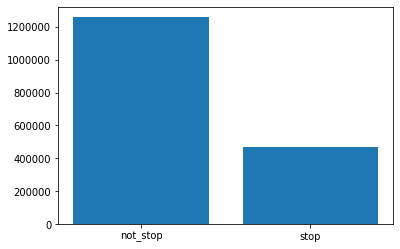

In [7]:
parsed_text=""
histogram=Counter()
for doc in docs:
    parsed_text=nlp(doc) 
    for token in parsed_text:
        if token.lemma_.lower() in stop_:
            histogram['stop']+=1
        else:
            histogram['not_stop']+=1


plt.bar(histogram.keys(), histogram.values())

## LDA Using Gensim
As mentioned previously LDA (Latent Dirichlet Allocation) is a type of topic model where each document is represented as a combination of topics and then words associated with each topic. For example in our case we have a dataset of news articles. Let's say someone wanted to look at all the articles which contained a certain phrase or word. However, they are more interested to see the context in which said phrase or word is mentioned. Ideally, they would like to have a set of topics assigned to each document and then look at the most dominant topics in the documents of interest (where the phrase is mentioned.). The algorithm will start by assigning a random probability distribution of topics. It will then 'learn' or adjust those distributions over time by looking at the text in those documents. 
A more detailed step by step explanation of the how the Algorithm is given [here](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/). The 'layman' scenario given here is a very interesting description of how LDA works.


We briefly used spaCy for nlp. We will now implement LDA using a python library called Gensim. We earlier manually did some pre-processing and used nlp() from spaCy for tokenization. Let's do the same thing using Gensim's built-in pre-processor.

A basic tutorial for gensim can be found [here](https://www.machinelearningplus.com/nlp/gensim-tutorial/)




In [0]:
import gensim
from gensim.utils import simple_preprocess


processed=[]  #this will be a list of lists of tokens
for doc in docs:
    processed.append(gensim.utils.simple_preprocess(str(doc), deacc=True))  #each document has now been converted to a list of tokens

We lemmatize the data as shown previously as well

In [0]:
lemmatized=[]
parts_of_speech=['NOUN', 'ADJ', 'VERB', 'ADV']
for doc in processed:
    tokenized=nlp(" ".join(doc))
    lemmatized.append([token.lemma_ for token in tokenized if token.pos_ in parts_of_speech])

                   
  


We already demonstrated how *stopwords* can adversely affect our analysis. So lets remove these from our data

In [0]:
filtered=[] 
for doc in lemmatized:
    filtered.append([token for token in doc if token not in stop_])

Next step is to create a dictionary and a Corpus which are then used as inputs for the LDA model. Corpus is a mapping between words and their frequencies. Each word is assigned an ID and a frequency is stored against each ID.

In [0]:
import gensim.corpora as corporus
dictionary=corporus.Dictionary(filtered) 
corpus = [dictionary.doc2bow(doc) for doc in filtered]


Time to fit the LDA model onto our data

In [0]:
warnings.filterwarnings('ignore') 
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,iterations=1000, num_topics=8)

The block below shows 8 topics and 8 words within each topic with a probability/weight assigned to them. The marginal probability here represents the likelihood of a document being assigned to a particulary topic given it has the word present in it. 
Even manually looking at these topics, it is easy to identify how words that seem related to the same topic are grouped together. For e.g look at Topic 7 and how the words are mostly related to stock trading.

In [113]:
lda.show_topics(num_topics=8, num_words=8)

[(0,
  '0.031*"year" + 0.026*"rise" + 0.022*"january" + 0.020*"february" + 0.014*"dlr" + 0.012*"fall" + 0.011*"price" + 0.010*"increase"'),
 (1,
  '0.014*"trade" + 0.010*"would" + 0.008*"dollar" + 0.007*"year" + 0.006*"company" + 0.006*"new" + 0.006*"market" + 0.005*"house"'),
 (2,
  '0.021*"tonne" + 0.019*"oil" + 0.012*"price" + 0.011*"year" + 0.008*"export" + 0.007*"stock" + 0.006*"production" + 0.006*"last"'),
 (3,
  '0.067*"net" + 0.058*"loss" + 0.045*"dlr" + 0.040*"shr" + 0.034*"profit" + 0.027*"year" + 0.018*"sale" + 0.017*"inc"'),
 (4,
  '0.013*"would" + 0.009*"price" + 0.008*"trade" + 0.007*"ec" + 0.007*"year" + 0.007*"export" + 0.006*"market" + 0.006*"import"'),
 (5,
  '0.049*"bank" + 0.026*"rate" + 0.019*"market" + 0.014*"stg" + 0.012*"money" + 0.011*"reserve" + 0.010*"dealer" + 0.008*"dollar"'),
 (6,
  '0.011*"japan" + 0.011*"year" + 0.008*"trade" + 0.008*"last" + 0.007*"official" + 0.007*"dlr" + 0.007*"would" + 0.006*"country"'),
 (7,
  '0.030*"share" + 0.027*"company" + 0.

Let's try something a little different now. Instead of looking at words we can look at combination of two or three words. We will now fit an LDA model as before but this time we will use 'bigrams' instead.

In [0]:
bigram=gensim.models.Phrases(processed, min_count=5, threshold=100)
make_bigrams = gensim.models.phrases.Phraser(bigram)
bigrams=[make_bigrams[doc] for doc in processed]
bigram_lemmatized=[]
parts_of_speech=['NOUN', 'ADJ', 'VERB', 'ADV']
for doc in bigrams:
    tokenized=nlp(" ".join(doc))
    bigram_lemmatized.append([token.lemma_ for token in tokenized if token.pos_ in parts_of_speech and token.lemma_ not in stop_])

corpus_bi = [dictionary.doc2bow(doc) for doc in bigram_lemmatized]
lda_bigram = gensim.models.ldamodel.LdaModel(corpus=corpus_bi, id2word=dictionary,iterations=1000,num_topics=8)



In [115]:
lda_bigram.show_topics(num_topics=8, num_words=8)

[(0,
  '0.027*"rise" + 0.024*"dlr" + 0.023*"year" + 0.018*"january" + 0.018*"february" + 0.014*"fall" + 0.013*"dollar" + 0.011*"bank"'),
 (1,
  '0.016*"year" + 0.015*"profit" + 0.010*"bank" + 0.009*"rate" + 0.009*"stg" + 0.007*"company" + 0.007*"mark" + 0.007*"would"'),
 (2,
  '0.014*"trade" + 0.013*"market" + 0.013*"would" + 0.012*"bank" + 0.010*"rate" + 0.007*"year" + 0.007*"japan" + 0.006*"government"'),
 (3,
  '0.083*"net" + 0.073*"loss" + 0.054*"dlr" + 0.050*"shr" + 0.036*"profit" + 0.034*"year" + 0.019*"rev" + 0.019*"note"'),
 (4,
  '0.050*"oil" + 0.022*"price" + 0.014*"barrel" + 0.012*"crude" + 0.010*"company" + 0.009*"cyclop" + 0.009*"production" + 0.008*"bpd"'),
 (5,
  '0.034*"share" + 0.029*"company" + 0.017*"inc" + 0.015*"stock" + 0.014*"dlr" + 0.014*"corp" + 0.014*"offer" + 0.011*"group"'),
 (6,
  '0.031*"tonne" + 0.019*"year" + 0.014*"price" + 0.013*"export" + 0.010*"production" + 0.009*"wheat" + 0.008*"corn" + 0.008*"last"'),
 (7,
  '0.027*"april" + 0.023*"bank" + 0.023*"

### Performance
An important question here for us is how good our model actually is. 
One way to judge the performance of our LDA model is to look at its Topic Coherence.
This in a way measures the quality of topics chosen by our model. For a more detailed explanation on evalutaion of Topic models please look [here](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/)

This metric tells us as expected that the model run on bigrams performed better than the simple version.


In [116]:
from gensim.models import CoherenceModel

coherence_lda = CoherenceModel(model=lda, texts=filtered, dictionary=dictionary, coherence='c_v')
print("Simple LDA coherence: ", coherence_lda.get_coherence())

coherence_lda_bi = CoherenceModel(model=lda_bigram, texts=bigram_lemmatized, dictionary=dictionary, coherence='c_v')
print("Bigram LDA coherence: ", coherence_lda_bi.get_coherence())


Simple LDA coherence:  0.4692954598128733
Bigram LDA coherence:  0.48254704849103647


Another way is to look at the perplexity of our models. Perplexity is a measure of how accurately the model predicts on our data set. 
The lower its value, the better it is.
A good brief explanation of how this is done for LDA models is given at [qpleple](http://qpleple.com/perplexity-to-evaluate-topic-models/)
.
As expected the bigram model has a better perplexity.

In [117]:
simple_perpex=lda.log_perplexity(corpus)
bigram_perpex=lda_bigram.log_perplexity(corpus)
print("Simple LDA model perplexity: ", simple_perpex)
print("Bigram LDA model perplexity: ", bigram_perpex)

Simple LDA model perplexity:  -7.508446990734312
Bigram LDA model perplexity:  -7.591179629107203


As with most models, the main challenge is not to fit a model from a library on a dataset. The decision making part comes into play for hyperparameter tuning. For example we arbitarily put in the number of topics as 8 when fitting the LDA model. How do we know this is the best choice? We do not. Not until we test out other possible values as well. Let's try doing that now on our vanilla version of the lda model.

In [0]:
warnings.filterwarnings('ignore')
coherence={}
max=0
for num in range(3,12,1):
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,iterations=1000, num_topics=num)
    coherence_lda= CoherenceModel(model=lda, texts=filtered, dictionary=dictionary, coherence='c_v')
    coherence[num]= coherence_lda.get_coherence()
    if coherence[num] > max:
        max=coherence[num]
        lda_best=lda


The plot below shows coherence against models fitted with a range of number of topics. The best choice here seems to be 7 which has the highest coherence value. This graph can obviously be plotted by using other metrics as well. Similarly we can also tune other hyperparameters using this methodology. Lets fit our model using the best number of topics hyperparameter.

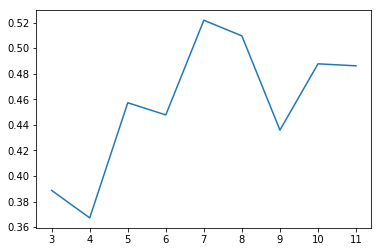

In [131]:
keysandvalues = sorted(coherence.items()) 

x,y=zip(*keysandvalues)
plt.plot(x,y)
plt.show()

In [132]:

lda_best.show_topics(num_topics=7, num_words=8)

[(0,
  '0.085*"net" + 0.084*"loss" + 0.054*"shr" + 0.045*"profit" + 0.039*"dlr" + 0.033*"year" + 0.022*"rev" + 0.019*"sale"'),
 (1,
  '0.016*"company" + 0.014*"april" + 0.013*"pay" + 0.013*"record" + 0.012*"div" + 0.011*"corp" + 0.010*"qtly" + 0.010*"prior"'),
 (2,
  '0.014*"bank" + 0.011*"oil" + 0.011*"market" + 0.011*"trade" + 0.010*"would" + 0.009*"rate" + 0.007*"dollar" + 0.006*"price"'),
 (3,
  '0.022*"year" + 0.019*"rise" + 0.013*"february" + 0.012*"january" + 0.012*"price" + 0.009*"fall" + 0.008*"export" + 0.008*"tonne"'),
 (4,
  '0.032*"share" + 0.020*"company" + 0.019*"inc" + 0.017*"stock" + 0.015*"corp" + 0.012*"offer" + 0.011*"dlr" + 0.009*"common"'),
 (5,
  '0.037*"dlr" + 0.016*"company" + 0.016*"year" + 0.013*"share" + 0.010*"dlrs" + 0.008*"earning" + 0.006*"would" + 0.006*"net"'),
 (6,
  '0.025*"tonne" + 0.013*"corn" + 0.012*"year" + 0.011*"grain" + 0.011*"wheat" + 0.010*"export" + 0.009*"production" + 0.008*"soviet"')]

An interesting way to visualize Topics from our model is using word clouds. We can do this using the [WordCloud](http://amueller.github.io/word_cloud/) library.

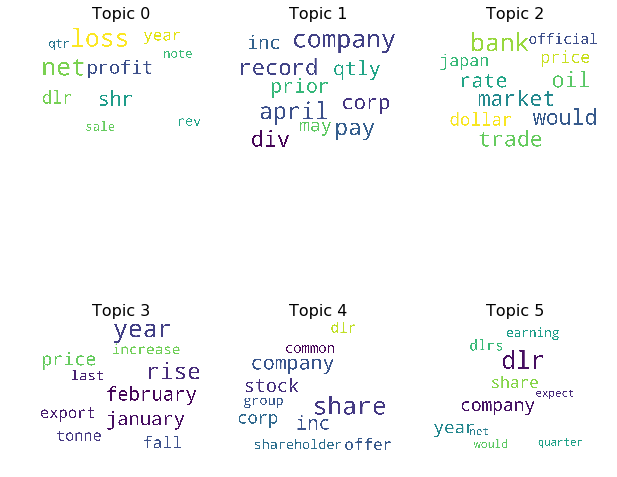

In [134]:
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stop_,
                  background_color='white',
                  width=2000,
                  height=1600,
                  max_words=10,
                  prefer_horizontal=1.0)

topics = lda_best.show_topics(formatted=False)
fig, axes = plt.subplots(2,3, figsize=(10,10), sharex=True, sharey=True)


####This part to display word clouds is taken from 
##https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    wordcloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

Going back to our original hypothetical scenario. Let's say we want to check the context in which certain phrases are being mentioned in a set of documents. We'll see what topics are associated with certain words. We'll set the minimum probability to be 0.1 for a topic to be important enough.

In [135]:
words = [["money"], ["export"], ["health"]]

for word in words:
    print("\nThe word "+str(word)+" is mentioned in the context of the topics below:")
    wordbow= dictionary.doc2bow(word)
    for topic, prob in lda_best.get_document_topics(wordbow, minimum_probability=0.1):
        print ("Topic: "+str(topic)+" with probability "+str(prob))
        print("The topic is dominated by these top 5 terms: ", lda_best.show_topic(topic, 5))


The word ['money'] is mentioned in the context of the topics below:
Topic: 2 with probability 0.571179
The topic is dominated by these top 5 terms:  [('bank', 0.014199713), ('oil', 0.011024585), ('market', 0.010631978), ('trade', 0.010598842), ('would', 0.010482069)]

The word ['export'] is mentioned in the context of the topics below:
Topic: 6 with probability 0.57078063
The topic is dominated by these top 5 terms:  [('tonne', 0.0251553), ('corn', 0.013295856), ('year', 0.011697712), ('grain', 0.010812089), ('wheat', 0.010503311)]

The word ['health'] is mentioned in the context of the topics below:
Topic: 4 with probability 0.57105315
The topic is dominated by these top 5 terms:  [('share', 0.03238659), ('company', 0.01993409), ('inc', 0.018641211), ('stock', 0.017122107), ('corp', 0.014615955)]


While the results above show some good results, as in the case of money and export, we also run into some limitations of the model as well as the dataset itself when we look at the result for 'health'. Nevertheless, LDA is a very useful algorithm for finding context of occurences.

The most common method to visualize LDA topics is by using the [**pyLDAvis**](https://pyldavis.readthedocs.io/en/latest/) library. It is able to generate an interactive chart which is insightful for exploring our results. We can see stats for each topic by hovering over the corresponding circle or by selecting a topic at the top. The circles on the left side chart are good for looking at inter topic distance.

In [136]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_best, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

We will now briefly go over another Topic Modeling technique called Latent Semantic Analysis (LSA). The idea behind this technique is to find the context of how words are used. It doesnt simply use words in documents to map to topics but also analyzes how those words are being used. To use this technique we will first have to create a document matrix of a x b dimensions where a is the number of documents (hence each row is a document) and b is the tf-idf scores of each word for that document(b is the number of unique words). 
[TF-IDF Scores](http://www.tfidf.com/)  are weights for each word in a document (higher the score, more important the word is). A document matrix can be generated using [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from sklearn. 
We will not go into exploring the results in detail with this technique as we did with gensim LDA. This is just to show a sample from other techniques that could be used for Topic Modeling. 
The code below is adapted from [this](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/) source


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

docs_for_vector=[]

#combine list of tokens back to a list of documents where each element is a list of words in a document
for i in range(len(filtered)):
    d = ' '.join(filtered[i])
    docs_for_vector.append(d)
    


df = pd.DataFrame({'doc':docs_for_vector})
df['docs'] = df['doc'].apply(lambda x: x.lower())

vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features= 1000,  max_df = 0.5, smooth_idf=True)

X = vectorizer.fit_transform(df['docs'])


The next step is to decompose this matrix in a way that we get each document and word as a vector. This is essentially a dimentionality reduction task. To break this down into smaller matrices we will use [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) from sklearn. The n_components in the SVD model hyperparameters specifies the number of topics we want. 

In [0]:
from sklearn.decomposition import TruncatedSVD
 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=100)
for_umap=svd_model.fit_transform(X)

Another great visualization for looking at inter topics distance is by using the [UMAP](https://umap-learn.readthedocs.io/en/latest/) library.

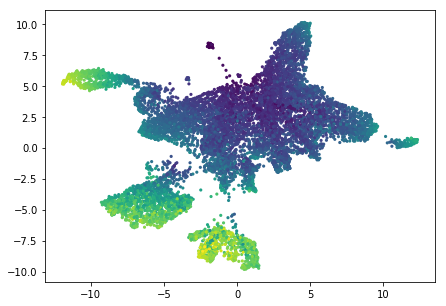

In [139]:
import umap


embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=10).fit_transform(for_umap)
colors=np.amax(for_umap,axis=1)
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = colors,
s = 10, # size
edgecolor='none'
)
plt.show()

## Sources:

### NLP, Tokenization, Lemmatization:
Some parts were adapted from my solution to an assignment for 95-865 

### LDA Using Gensim:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ <br/>
https://radimrehurek.com/gensim/models/ldamodel.html <br/>
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24 <br/>
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ <br/>
https://www.datacamp.com/community/tutorials/lda2vec-topic-model


### pyLDAvis:
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
https://pyldavis.readthedocs.io/en/latest/

### LSA and UMAP:
https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


**Other references** are also given throughout the notebook as hyperlinks



